## FORMULA 1 PROJECT- Generate Predictions

In [1]:
%run F1_functions.ipynb

/Users/dianaow/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [84]:
train_set = read_from_pickle(directory, "train_set.pickle")
test_set = read_from_pickle(directory, "test_set.pickle")

In [85]:
dataset = pd.concat([train_set, test_set])

In [74]:
# Standardize variables 
njobs = 4
rs=12

index_list = ['year', 'name', 'driverRef']
target_var_list = ['statusId']

xl = pd.ExcelFile("/Users/dianaow/Downloads/F1_Tyre_data.xlsx")
xl.sheet_names
pirelli = xl.parse("Sheet7")
races_dict = pirelli[['year', 'name']].to_dict('list')
races = list(status_dataset_train.name.unique())
num_of_races = len(races)

In [4]:
# create a dummy class for no sampling
class NoSampling(object):
    
    def fit_sample(self, X, y):
        return X, y
    
samplers = [
    ['No Sampling', NoSampling()],
    #['Random Oversampler', RandomOverSampler(random_state=rs)],
    #['SMOTE', SMOTE(ratio='minority', k_neighbors=1, random_state=rs)],
    #['SMOTE ENN', SMOTEENN(random_state=rs)]
]

skfold = StratifiedKFold(n_splits=10, random_state=rs, shuffle=True)

## 1d) First-Level Predictions (Without hyperparameter tuning)

In [5]:
sel_classifiers = [
    
    ['Random Forest', RandomForestClassifier(random_state=rs, class_weight=None)],
    ['LDA', LinearDiscriminantAnalysis()],
    ['MLP', MLPClassifier(random_state=rs)],
    ['Gradient Boosting', GradientBoostingClassifier(random_state=rs)],
    ['Extra Trees',  ExtraTreesClassifier(random_state=rs)],
]

sel_clfs_repeated = [sel_classifiers] * num_of_races

In [52]:
results_binary_test1, pred_binary_test1, pred_binary_train1, proba_binary_test1, proba_binary_train1 = singletarget_PREDICTION_loop(
    
    dataset, test_set, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', sel_clfs_repeated, samplers, skfold, races, races_dict, meta_learner='' \
)

results_binary_test1[results_binary_test1['Test accuracy'] > results_binary_test1['Baseline accuracy']]

,Index,Target Var,Method,Resampler,Baseline accuracy,Test accuracy,F1 Score,Avg Precision
0,Australian Grand Prix,statusId,Random Forest,No Sampling,0.631579,0.736842,"[0.444444444444, 0.827586206897]",0.705882
0,Australian Grand Prix,statusId,MLP,No Sampling,0.631579,0.684211,"[0.4, 0.785714285714]",0.682840
0,Bahrain Grand Prix,statusId,Random Forest,No Sampling,0.650000,0.700000,"[0.25, 0.8125]",0.684211
0,Bahrain Grand Prix,statusId,LDA,No Sampling,0.650000,0.700000,"[0.4, 0.8]",0.701584
0,Bahrain Grand Prix,statusId,Gradient Boosting,No Sampling,0.650000,0.700000,"[0.4, 0.8]",0.701584
0,Russian Grand Prix,statusId,LDA,No Sampling,0.800000,0.850000,"[0.4, 0.914285714286]",0.842105
0,Monaco Grand Prix,statusId,Gradient Boosting,No Sampling,0.684211,0.736842,"[0.285714285714, 0.838709677419]",0.722222
0,Austrian Grand Prix,statusId,MLP,No Sampling,0.800000,0.850000,"[0.4, 0.914285714286]",0.842105
0,Belgian Grand Prix,statusId,Gradient Boosting,No Sampling,0.800000,0.850000,"[0.4, 0.914285714286]",0.842105
0,Italian Grand Prix,statusId,Extra Trees,No Sampling,0.800000,0.850000,"[0.4, 0.914285714286]",0.842105


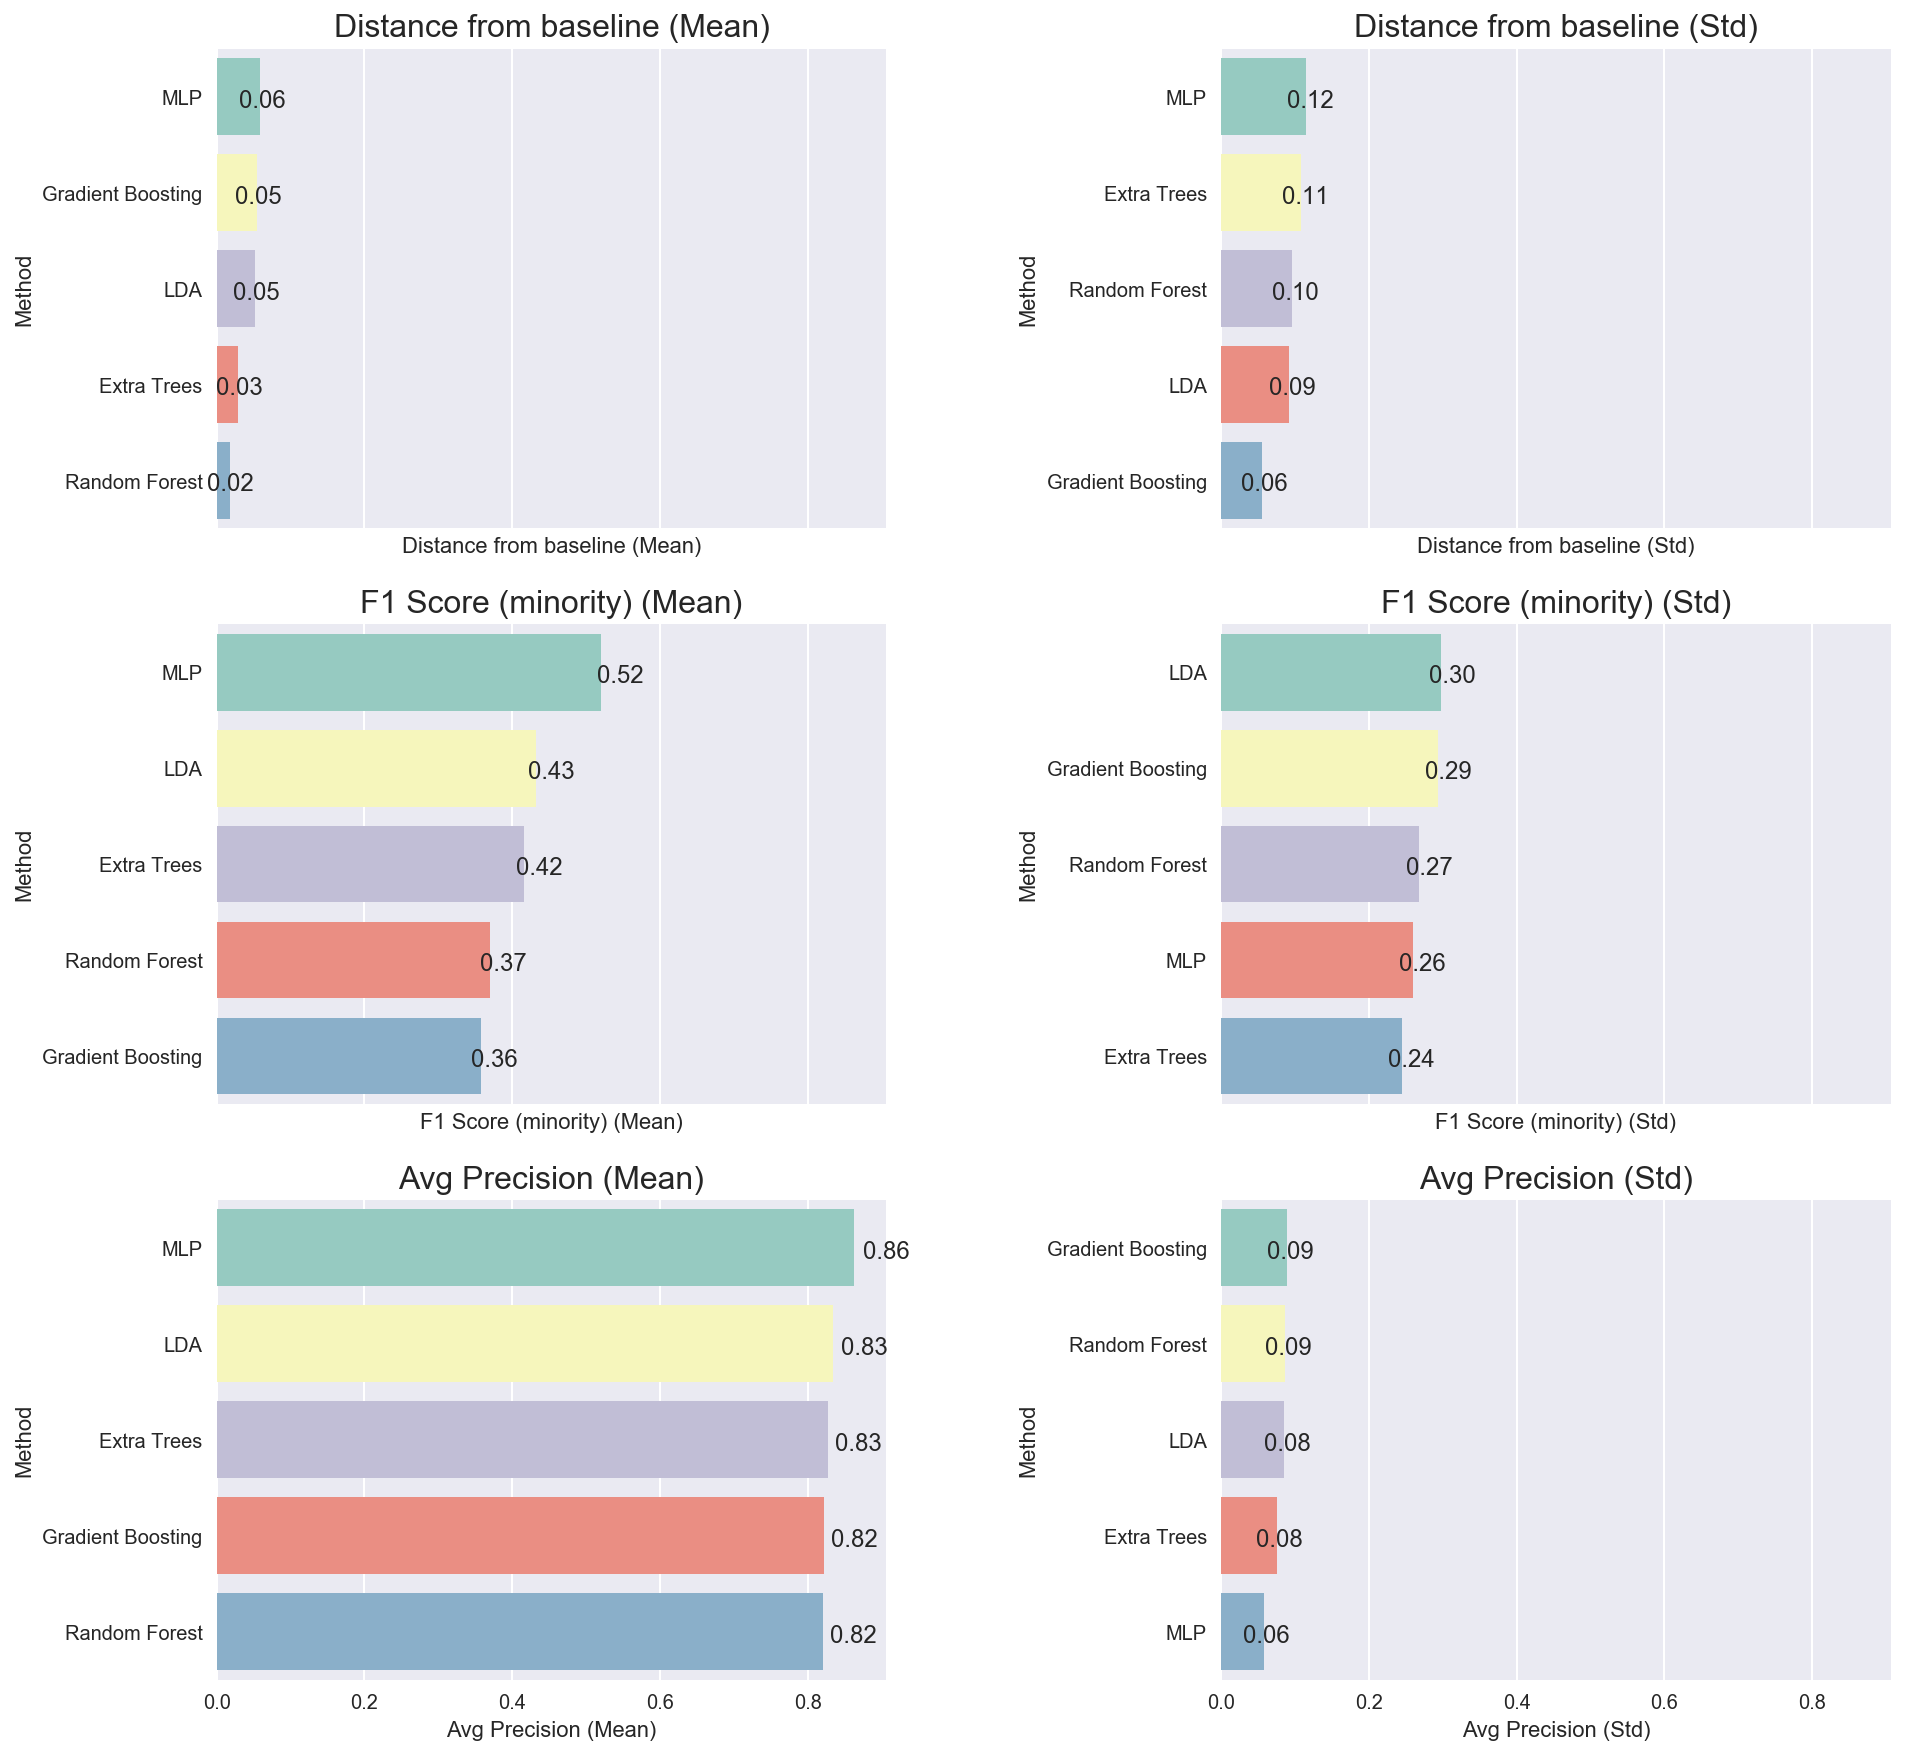

In [30]:
results_binary_test1 = format_stats_df(results_binary_test1, ['F1 Score'])
metrics_list = ["Distance from baseline", "F1 Score (minority)", 'Avg Precision']
rbt = plot_algo_results(results_binary_test1, "Method", metrics_list, 'desc')

#### Evaluation: Without parameter hypertuning, only 4 races have prediction accuracy beyond baseline. The untuned RF Classifier works very well in prediction for Chinese Grand Prix with the highest test accuracy. 

## 1e) First-Level Predictions (With hyperparameter tuning)

In [92]:
tuned_cls_top3 = read_from_pickle(directory, "tuned_cls_top3.pickle")
print("Total number of tuned classifiers to test per race:", len(tuned_cls_top3[0]))

('Total number of tuned classifiers to test per race:', 11)


In [96]:
results_binary_test_tuned, pred_T, pred_train_T, proba_T, proba_train_T = singletarget_PREDICTION_loop(
    
    dataset, test_set, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', tuned_cls_top3, samplers, skfold, races, races_dict, meta_learner=""\
)

In [97]:
abv_eql_baseline = results_binary_test_tuned[results_binary_test_tuned['Test accuracy'] >= results_binary_test_tuned['Baseline accuracy']]
abv_baseline = results_binary_test_tuned[results_binary_test_tuned['Test accuracy'] > results_binary_test_tuned['Baseline accuracy']]
abv_baseline

,Index,Target Var,Method,Resampler,Baseline accuracy,Test accuracy,F1 Score,Avg Precision
0,Chinese Grand Prix,statusId,RandomForest4,No Sampling,0.789474,0.842105,"[0.4, 0.909090909091]",0.833333
0,Bahrain Grand Prix,statusId,RandomForest3,No Sampling,0.650000,0.700000,"[0.25, 0.8125]",0.684211
0,Bahrain Grand Prix,statusId,GradientBoosting6,No Sampling,0.650000,0.700000,"[0.25, 0.8125]",0.684211
0,Bahrain Grand Prix,statusId,GradientBoosting7,No Sampling,0.650000,0.700000,"[0.25, 0.8125]",0.684211
0,Bahrain Grand Prix,statusId,LinearDiscriminantAnalysis10,No Sampling,0.650000,0.700000,"[0.4, 0.8]",0.701584
0,Russian Grand Prix,statusId,ExtraTrees2,No Sampling,0.800000,0.850000,"[0.4, 0.914285714286]",0.842105
0,Russian Grand Prix,statusId,RandomForest3,No Sampling,0.800000,0.850000,"[0.571428571429, 0.909090909091]",0.877206
0,Russian Grand Prix,statusId,RandomForest5,No Sampling,0.800000,0.850000,"[0.571428571429, 0.909090909091]",0.877206
0,Russian Grand Prix,statusId,LinearDiscriminantAnalysis10,No Sampling,0.800000,0.850000,"[0.4, 0.914285714286]",0.842105
0,Canadian Grand Prix,statusId,GradientBoosting8,No Sampling,0.750000,0.800000,"[0.333333333333, 0.882352941176]",0.789474


In [98]:
abv_baseline.groupby('Method')['Index'].count().sort_values(ascending=False)

Method
RandomForest5                   4
RandomForest4                   4
RandomForest3                   4
GradientBoosting8               4
GradientBoosting7               3
LinearDiscriminantAnalysis10    2
GradientBoosting6               2
ExtraTrees2                     2
MLP9                            1
Name: Index, dtype: int64

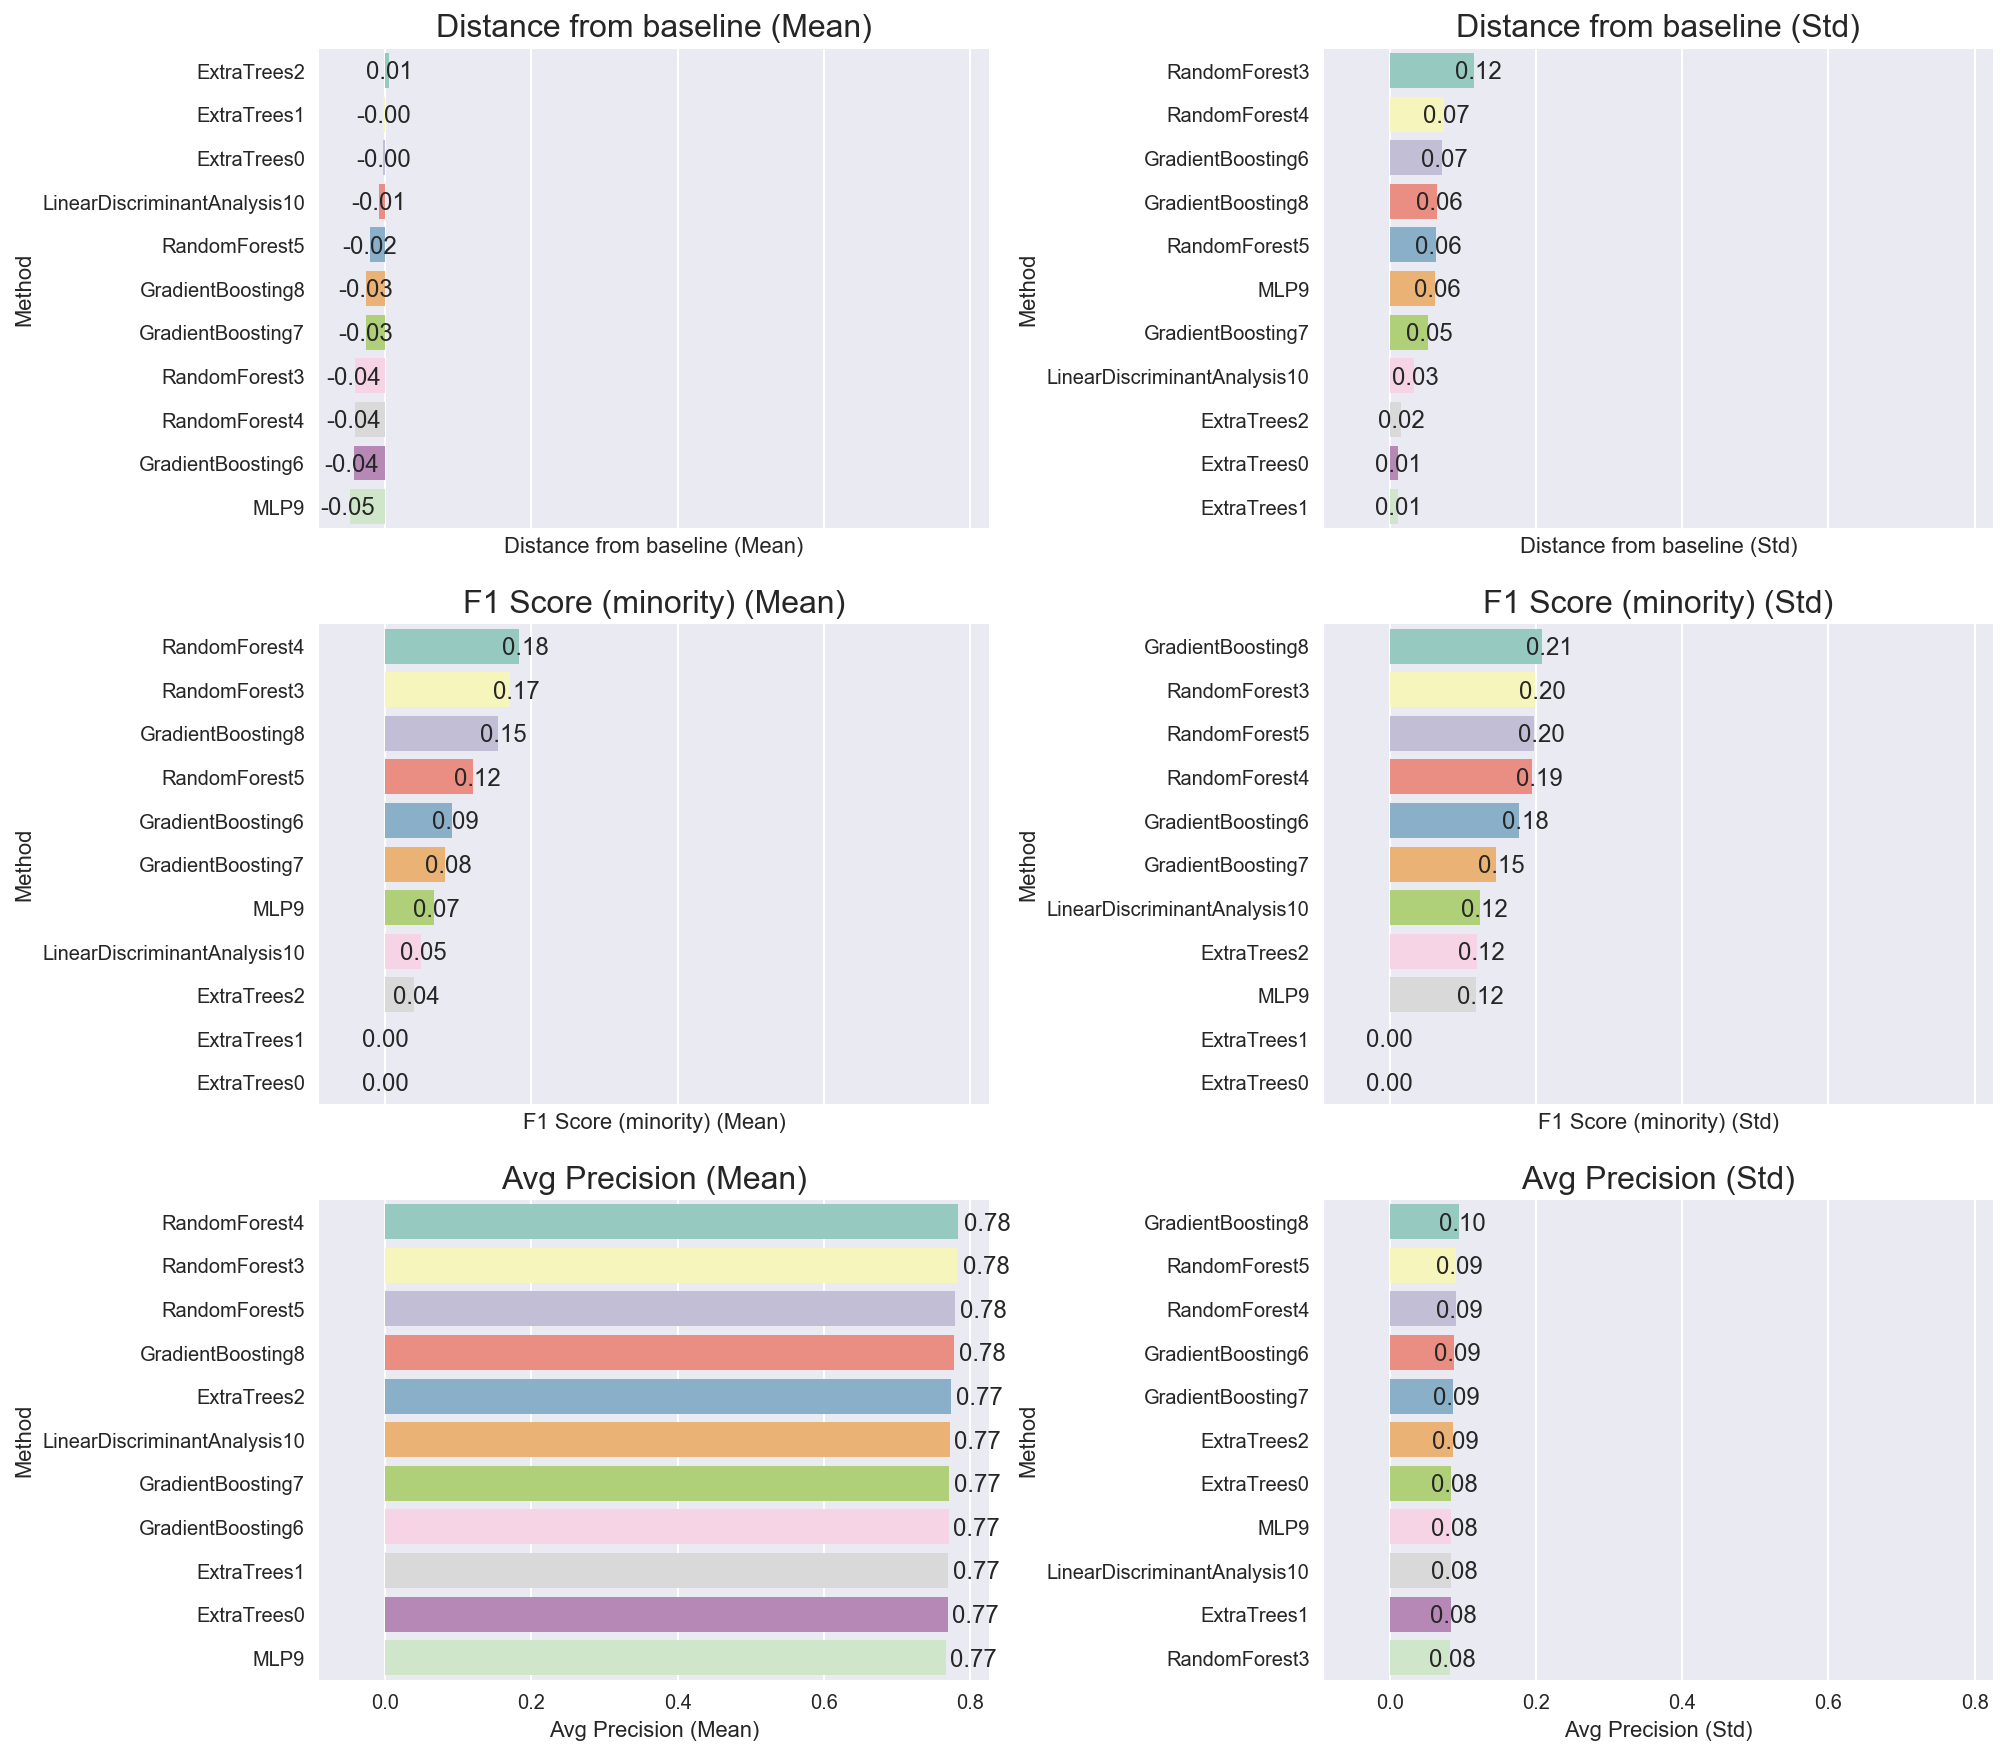

In [100]:
results_binary_test_tuned1 = format_stats_df(results_binary_test_tuned, ['F1 Score'])
metrics_list = ["Distance from baseline", "F1 Score (minority)", 'Avg Precision']
rbtt = plot_algo_results(results_binary_test_tuned1, "Method", metrics_list, 'desc')

### Feature importance of tree based classifiers

In [101]:
cols_f = np.setdiff1d(test_set.columns, np.array(index_list + target_var_list))
test_set_plot = test_set.loc[:, cols_f]

#### Plot for only one race -  Australian Grand Prix

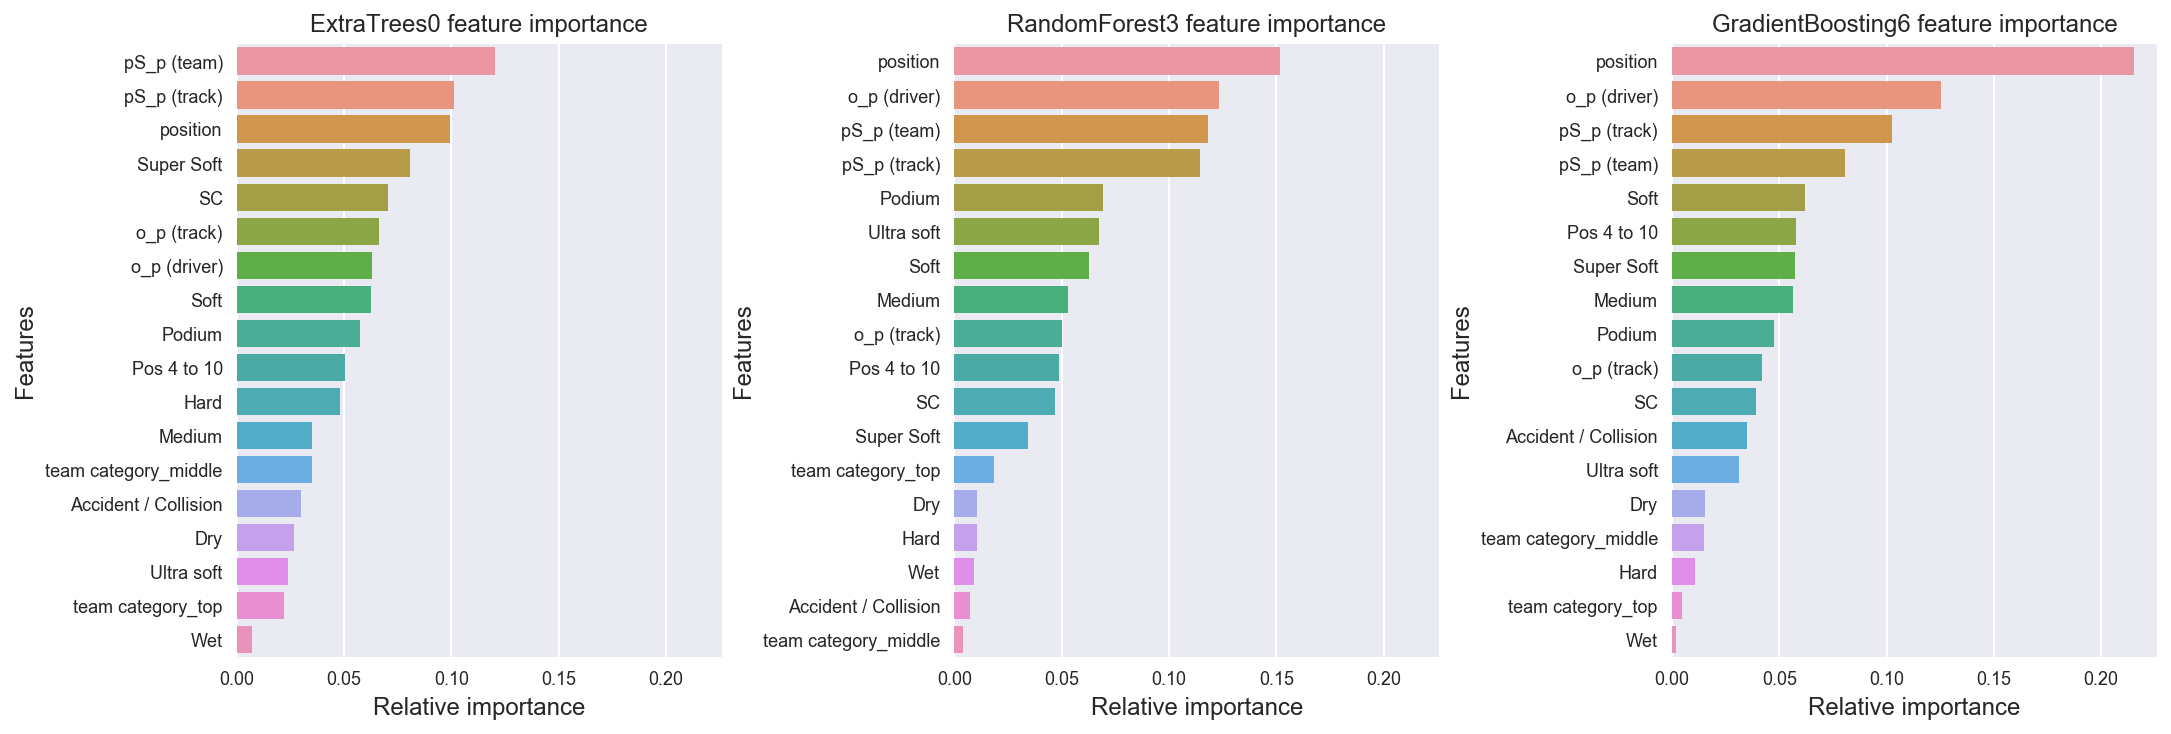

In [109]:
names_classifiers = tuned_cls_top3[0][0::3][:-1]

nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex="all", figsize=(15,5), squeeze=False)

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=test_set_plot.columns[indices][:40], x = classifier.feature_importances_[indices][:40] ,
                        orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Check correlation of first-level prediction probabilities amongst various models
#### Plot for only one race -  Australian Grand Prix

In [20]:
def extract_pred(df, clfs):
    df_all = pd.DataFrame()
    for i in clfs:
        f = df[df['classifier'] == i][['statusId_predicted']].rename(columns={'statusId_predicted': i})
        df_all = pd.concat([df_all, f], axis=1)
        
    return df_all

# Use heatmap to check for correlation

def gen_mask(df):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True         
    return mask

In [110]:
results_binary_test_tuned, pred_T, pred_train_T, proba_T, proba_train_T = singletarget_PREDICTION_loop(
    
    status_dataset_train, status_dataset_test, [2016], [2017], index_list, target_var_list, \
    'StandardScaler', tuned_cls_top3, samplers, skfold, races[0:1], races_dict, meta_learner=""\
)

('Size of train set:', (439, 11))
('Size of test set:', (19, 11))


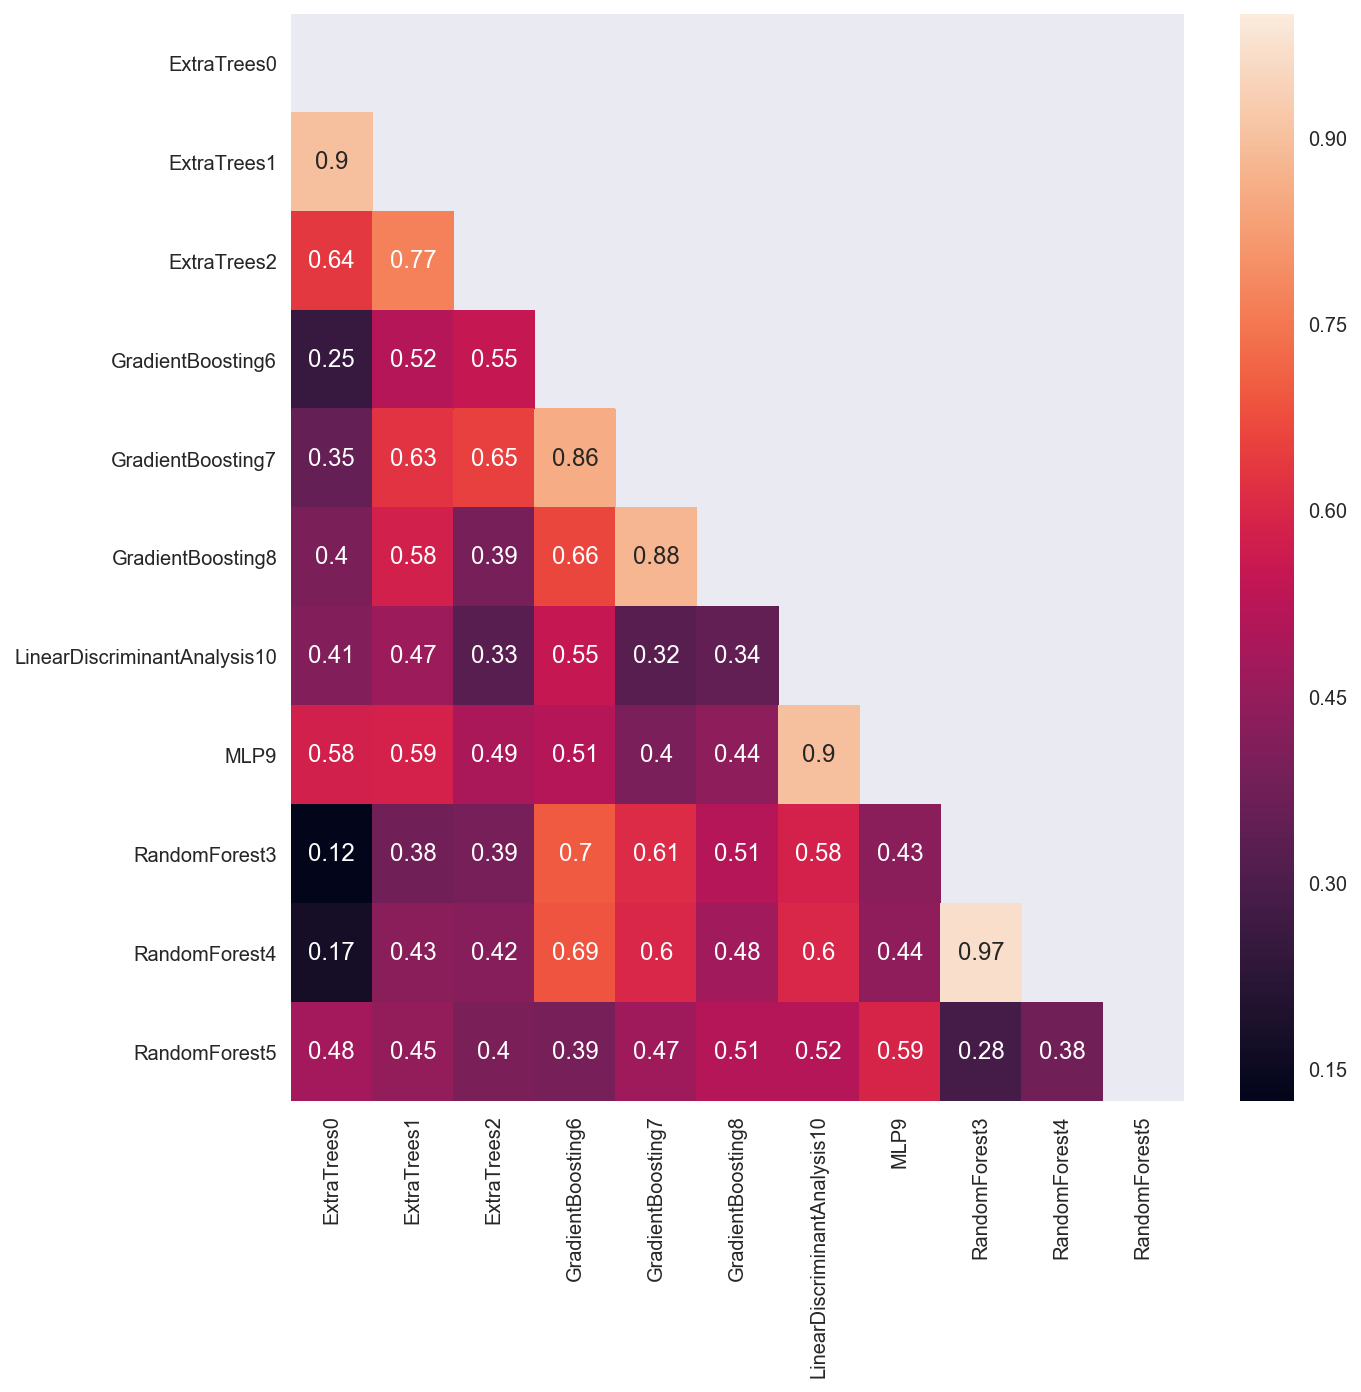

In [113]:
# Matrix of first level prediction results

clfs_titles = np.unique([x[0] for i in tuned_cls_top3 for x in i])
ensemble_results_test = extract_pred(proba_T, clfs_titles)
ensemble_results_train = extract_pred(proba_train_T, clfs_titles)

print("Size of train set:", ensemble_results_train.shape)
print("Size of test set:", ensemble_results_test.shape)

sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ensemble_results_test.corr(), mask=gen_mask(ensemble_results_test.corr()), annot=True, ax=ax)